# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The assignment I received only came with this instruction:
`Your job as a data scientist is in this assignment is to examine a set of job postings with salaries and then predict salaries for a new set of job postings.`

The data provided in both the training and testing dataset has the following features:
- companyId
- jobType
- degree
- major
- industry
- yearsExperience
- milesFromMetropolis

I didn't receive any additional background or information about why I'd be asked to do this. Understanding the "why" behind any data science project is crucial. If this were a real project, I would ask the following questions:

- Who are the ultimate end users of this project?
- Where does the source data come from?
- What are the main issues they are trying to solve?
- How are they solving those issues right now?
- What are the issue/disadvantages of the current approach?
- What are the key components to a successful model?

**For the purposes of this exercise, I will assume the following:**

The human resources department has requested this project. They obtained the data about job posting salaries from an independent salary research firm. The research firm claims that the data was collected within the last year from comparable companies.

The HR department would like to ensure that the company offers competitive salaries, not too high or too low. They would like to include a predicted salary as a reference point in their decision of whether or not to approve salaries for job postings.

At the moment, they are using rough salary bands provided by the salary reasearch firm as a reference point. However, these are only based on the generic job title (CEO, CFO, Janitor, etc), and the HR department feels that it would be good to include a few other factors to get a more specific salary estimate.

A successful model would be able to predict a salary based on the features provided in the datasets.

**Other items to consider**

In order to make a more accurate model, it would be good to include other features in the data. For example, the specific market that the job is in will likely have a large impact on the salary. Also, there are other components to compensation that may be worth considering as well, such as bonus, vacation days, etc. It would also be good to have more information about things like company size. In my model, I haven't removed any industries, but it would likely be appropriate to focus only on the industry of the target client. 

While job postings are an interesting data point, it is important to remember that they do not represent the actual salaries ultimately agreed upon. It would be good to consider the cost of acquiring actual salary data which could be used in defining guidelines for appropriate salary bands and salary negotiations.

In [1]:
import pandas as pd
import seaborn as sns
sns.set_color_codes("deep")
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
#import sklearn as sk

__author__ = "Steve Anderson"
__email__ = "steve@ranksmarts.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
train_feat = pd.read_csv('data/train_features.csv',index_col='jobId')
print("Rows and columns in train_feat:",train_feat.shape)
train_feat.head(3)

Rows and columns in train_feat: (1000000, 7)


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38


In [3]:
train_salaries = pd.read_csv('data/train_salaries.csv',index_col='jobId')
print("Rows and columns in train_salaries:",train_salaries.shape)
train_salaries.head(3)

Rows and columns in train_salaries: (1000000, 1)


,salary
jobId,
JOB1362684407687,130
JOB1362684407688,101
JOB1362684407689,137


In [4]:
test_feat = pd.read_csv('data/test_features.csv',index_col='jobId')
print("Rows and columns in test_feat:",test_feat.shape)
test_feat.head(3)

Rows and columns in test_feat: (1000000, 7)


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9


### ---- 3 Clean the data ----

In [5]:
#Check for duplicates in all feature columns of training data

features = ['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis']

train_feat_dups = train_feat[train_feat.duplicated(features,keep=False)]
print("Number of rows with duplicate data in train_feat:",len(train_feat_dups))

Number of rows with duplicate data in train_feat: 15917


This shows that there are 15,917 records in the training set that have at least one other record that is identical on all features. I'm curious to see if we include the salaries for those records if they will also be identical, or if they'll be different.

In [6]:
# Add salary column to 'train_feat' data

train_w_salary = train_feat.join(train_salaries)
print("Rows and columns in train_w_salary:",test_feat.shape)
train_w_salary.head(3)

Rows and columns in train_w_salary: (1000000, 7)


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


In [7]:
features2 = ['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary']

train_w_salary_dups = train_w_salary[train_w_salary.duplicated(features2,keep=False)]
print("Number of rows with duplicate data in train_w_salary:",len(train_w_salary_dups))

Number of rows with duplicate data in train_w_salary: 372


It looks like there are a lot fewer rows (372 vs 15,917) that are duplicates on all features when salary is included. This means that there are many rows that are the same on all characteristics except for salary. Let's take a look at some of these records to see if we can figure out what's going on.

In [8]:
#First 10 records of data that are identical except for jobId and salary

dups_w_salary = train_w_salary[train_feat.duplicated(features,keep=False)]
dups_w_salary.sort_values(features).head(10)

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362685003735,COMP0,CEO,BACHELORS,BIOLOGY,SERVICE,23,34,214
JOB1362685283347,COMP0,CEO,BACHELORS,BIOLOGY,SERVICE,23,34,122
JOB1362685004580,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,0,82,129
JOB1362685288664,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,0,82,97
JOB1362685165440,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,15,13,125
JOB1362685283913,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,15,13,156
JOB1362684435928,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,23,94,136
JOB1362684748853,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,23,94,105
JOB1362684556793,COMP0,CEO,HIGH_SCHOOL,NONE,EDUCATION,11,63,106


This looks strange. First of all, it appears as if most of these have been duplicated, but with VERY different salary data. Just look at the first two rows. A CEO position requiring 23 years of experience, 34 miles from a metropolis, with a salary of 122 or 214? This doesn't make any sense.

In [9]:
# Let me look at some high level numbers to see if anything else looks weird in this dataset

dups_w_salary.describe()

,yearsExperience,milesFromMetropolis,salary
count,15917.000000,15917.000000,15917.000000
mean,11.869825,49.637683,95.311679
std,7.196198,29.097380,37.297904
min,0.000000,0.000000,17.000000
25%,6.000000,24.000000,67.000000
50%,12.000000,49.000000,91.000000
75%,18.000000,75.000000,119.000000
max,24.000000,99.000000,260.000000


In [10]:
# And reviewing the non-numerical fields as well

text_features = ['companyId','jobType','degree','major','industry']
dups_w_salary[text_features].describe()

,companyId,jobType,degree,major,industry
count,15917,15917,15917,15917,15917
unique,63,8,5,9,7
top,COMP32,JANITOR,NONE,NONE,FINANCE
freq,308,6811,7409,14733,2380


It doesn't appear that this anomaly is concentrated in any single feature, although most of the issues do appear when the major is "none". I don't think I'm going to dig any deeper at this point. It just makes sense to remove these duplicat rows. Since I have no way of knowing which salary number is correct, I'll remove the duplicates from all rows.

In [11]:
#drop duplicates from train_feat dataset

train_feat.drop(dups_w_salary.index,inplace=True)
train_feat.shape

(984083, 7)

In [12]:
#drop duplicates from train_salary dataset

train_salaries.drop(dups_w_salary.index,inplace=True)
train_salaries.shape

(984083, 1)

In [13]:
#review duplicates in test_feat dataset

filt = test_feat.duplicated(features,keep=False)
test_feat[filt].sort_values(features)

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362685464148,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,4,80
JOB1362686275559,COMP0,CEO,HIGH_SCHOOL,NONE,AUTO,4,80
JOB1362685526996,COMP0,CEO,HIGH_SCHOOL,NONE,HEALTH,22,83
JOB1362686243166,COMP0,CEO,HIGH_SCHOOL,NONE,HEALTH,22,83
JOB1362685975334,COMP0,CEO,NONE,NONE,EDUCATION,16,61
...,...,...,...,...,...,...,...
JOB1362686221098,COMP9,VICE_PRESIDENT,NONE,NONE,HEALTH,24,23
JOB1362685955412,COMP9,VICE_PRESIDENT,NONE,NONE,SERVICE,5,15
JOB1362686128323,COMP9,VICE_PRESIDENT,NONE,NONE,SERVICE,5,15


In [14]:
#since we will be predicting these salaries, we will drop all non-unique rows

test_feat.drop_duplicates(features,inplace=True)
test_feat.shape

(991954, 7)

In [15]:
train_w_salary.drop(dups_w_salary.index,inplace=True)
train_w_salary.shape

(984083, 8)

In [16]:
#Review numerical columns for other anomalies
train_w_salary.describe()

,yearsExperience,milesFromMetropolis,salary
count,984083.000000,984083.000000,984083.000000
mean,11.994368,49.527506,116.397440
std,7.212639,28.874178,38.649051
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,89.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


It looks like there are some rows with a salary of zero. Let's take a look at those records.

In [17]:
#Select rows with zero salary

zero_salary = train_w_salary['salary'] <= 0
train_w_salary[zero_salary]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [18]:
#Drop rows with zero salary from datasets

train_feat.drop(train_w_salary[zero_salary].index,inplace=True)
train_salaries.drop(train_w_salary[zero_salary].index,inplace=True)
train_w_salary.drop(train_w_salary[zero_salary].index,inplace=True)
train_salaries

,salary
jobId,
JOB1362684407687,130
JOB1362684407688,101
JOB1362684407689,137
JOB1362684407690,142
JOB1362684407691,163
...,...
JOB1362685407682,88
JOB1362685407683,160
JOB1362685407684,64


### ---- 4 Explore the data (EDA) ----

In [19]:
#summarize continuous variables

train_w_salary.describe()

,yearsExperience,milesFromMetropolis,salary
count,984078.000000,984078.000000,984078.000000
mean,11.994390,49.527629,116.398031
std,7.212638,28.874166,38.648258
min,0.000000,0.000000,18.000000
25%,6.000000,25.000000,89.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


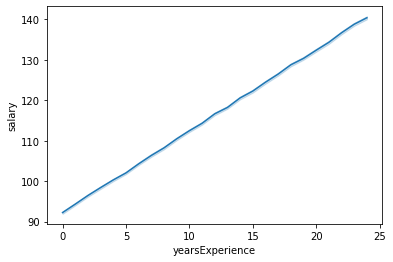

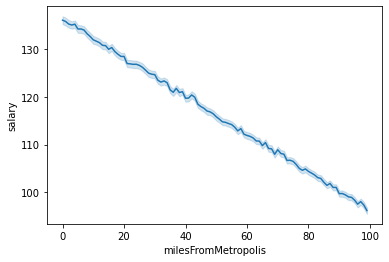

In [20]:
#graph correlation between continuous variables and salary

plt.figure()
sns.lineplot(x="yearsExperience", y="salary", data=train_w_salary)
plt.figure()
sns.lineplot(x="milesFromMetropolis", y="salary", data=train_w_salary)

In [21]:
#Summarize categorical variables

train_w_salary[text_features].describe()

,companyId,jobType,degree,major,industry
count,984078,984078,984078,984078,984078
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,15933,124528,229819,517620,140904


In [22]:
train_w_salary.groupby('companyId')['salary'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
companyId,,,,,,,,
COMP53,15540.0,115.669305,38.624364,22.0,88.0,114.0,141.0,278.0
COMP37,15658.0,115.716567,38.578881,20.0,88.0,113.0,141.0,285.0
COMP57,15405.0,115.737163,38.407085,19.0,88.0,114.0,141.0,263.0
COMP42,15659.0,115.833003,38.720676,19.0,88.0,113.0,141.0,281.0
COMP31,15499.0,115.897090,38.432014,24.0,89.0,114.0,140.0,283.0
...,...,...,...,...,...,...,...,...
COMP41,15574.0,116.910107,38.978871,21.0,89.0,114.0,143.0,268.0
COMP44,15724.0,116.972144,38.742389,20.0,90.0,115.0,142.0,294.0
COMP13,15689.0,117.001976,38.795415,21.0,89.0,115.0,142.0,273.0


It appears that companyID is not a strong predictor of salary.

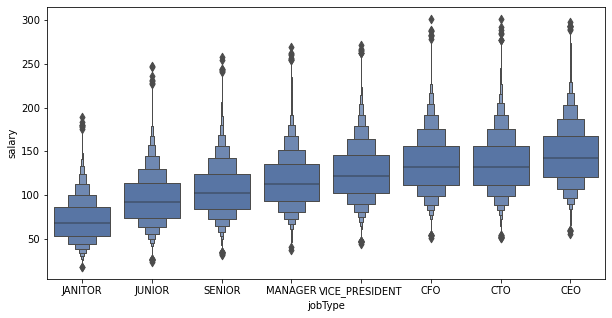

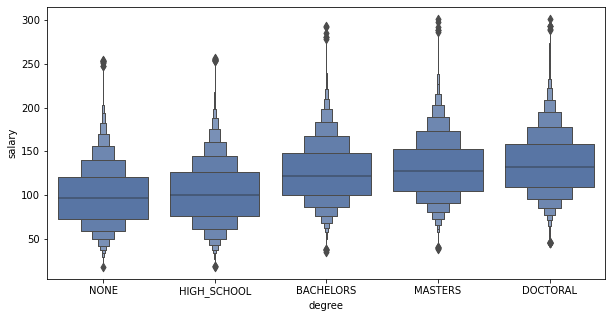

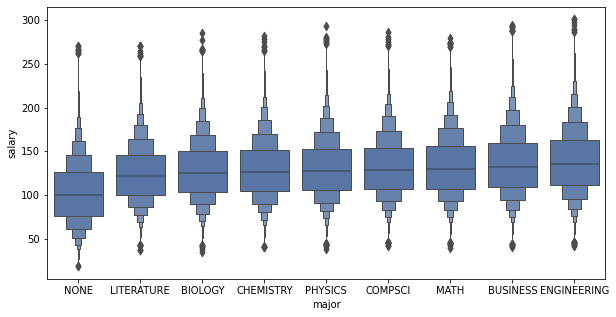

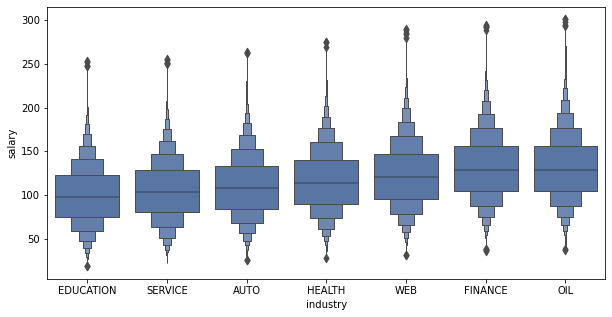

In [23]:
#graph correlation between categorical variables and salary

jobtype_ranking = train_w_salary.groupby('jobType')['salary'].median().sort_values().index.to_list()
fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
jobtype_distro = sns.boxenplot(x='jobType', y='salary', color='b', order=jobtype_ranking, data=train_w_salary, ax=ax)

fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
degree_ranking = train_w_salary.groupby('degree')['salary'].median().sort_values().index.to_list()
sns.boxenplot(data=train_w_salary, x='degree', y='salary', color='b', order=degree_ranking, ax=ax)

fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
major_ranking = train_w_salary.groupby('major')['salary'].median().sort_values().index.to_list()
sns.boxenplot(data=train_w_salary, x='major', y='salary', color='b', order=major_ranking, ax=ax)

fig_dims = (10,5)
fig, ax = plt.subplots(figsize=fig_dims)
industry_ranking = train_w_salary.groupby('industry')['salary'].median().sort_values().index.to_list()
sns.boxenplot(data=train_w_salary, x='industry', y='salary', color='b', order=industry_ranking, ax=ax)

### ---- 5 Establish a baseline ----

Before building more complex models, I'll start by creating a simple baseline model. After reviewing the above charts, it's apparent that the jobType is a major differentiator in salary, which makes sense. So the baseline model will use the average salary by jobType as a predictor for salary.

In [24]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

baseline_df = train_w_salary.groupby('jobType', as_index = False).mean().sort_values('salary').round(2)
baseline_df.rename(columns = {'salary':'avg_salary'}, inplace = True)
baseline_df = baseline_df[['jobType', 'avg_salary']]
baseline_df

,jobType,avg_salary
3,JANITOR,70.83
4,JUNIOR,95.42
6,SENIOR,105.59
5,MANAGER,115.46
7,VICE_PRESIDENT,125.47
1,CFO,135.55
2,CTO,135.58
0,CEO,145.41


In [25]:
baseline_df = pd.merge(train_w_salary, baseline_df, on = 'jobType')
baseline_df.head(3)

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,avg_salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,135.55
1,COMP15,CFO,NONE,NONE,HEALTH,23,24,178,135.55
2,COMP27,CFO,BACHELORS,CHEMISTRY,AUTO,9,70,131,135.55


In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(baseline_df['salary'], baseline_df['avg_salary']).round(0)

966.0

We can use the MSE of 966 for the average salaries compared to the actually salaries as our baseline. The goal is to lower the MSE below 360 with at least one models.

### ---- 6 Hypothesize solution ----

It's understandable that just using the average salary by Job Type is not the most accurate model. Almost all of the features demostrate some kind of predictive behavior, with years of Experience and miles from metropolis being strong indicators. CompanyID is the least predictive, and I don't think it would add value to consider it as a factor.

I will use Random Forest, KNN, and XGBoost, which should all provide superior performance to the baseline model.

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [27]:
#Create numeric columns so label encoding can be used for categorical variables in models

train_w_salary['jobType_num'] = train_w_salary['jobType'].apply(lambda x: jobtype_ranking.index(x))
train_w_salary['degree_num'] = train_w_salary['degree'].apply(lambda x: degree_ranking.index(x))
train_w_salary['major_num'] = train_w_salary['major'].apply(lambda x: major_ranking.index(x))
train_w_salary['industry_num'] = train_w_salary['industry'].apply(lambda x: industry_ranking.index(x))

# Separate target from predictors
y = train_w_salary.salary              
train_w_salary.drop(['salary'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_w_salary.columns if train_w_salary[cname].dtype in ['int64', 'float64']]
X = train_w_salary[numeric_cols].copy()

### ---- 8 Create models ----

In [28]:
from sklearn.ensemble import RandomForestRegressor
RFR_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)

from sklearn.neighbors import KNeighborsRegressor
KNR_model = KNeighborsRegressor(n_jobs=-1)

from xgboost import XGBRegressor
XG_model = XGBRegressor()

### ---- 9 Test models ----

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
scores = -1 * cross_val_score(RFR_model, X, y,
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error')

print("MSE scores for Random Forest Regressor:\n", scores)
print("Average MSE for Random Forest Regressor:", sum(scores)/5)

MSE scores for Random Forest Regressor:
 [447.20043632 446.41239079 449.02204147 443.55111076 443.97782131]
Average MSE for Random Forest Regressor: 446.03276013138213


In [31]:
scores = -1 * cross_val_score(KNR_model, X, y,
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error')

print("MSE scores for K Nearest Neighbors Regressor:\n", scores)
print("Average MSE for K Nearest Neighbors Regressor:", sum(scores)/5)

MSE scores for K Nearest Neighbors Regressor:
 [442.88415982 440.94390111 443.14422303 440.80718705 439.47936753]
Average MSE for K Nearest Neighbors Regressor: 441.4517677084735


In [32]:
scores = -1 * cross_val_score(XG_model, X, y,
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_mean_squared_error')

print("MSE scores for K Nearest Neighbors Regressor:\n", scores)
print("Average MSE for K Nearest Neighbors Regressor:", sum(scores)/5)

MSE scores for K Nearest Neighbors Regressor:
 [361.42406184 359.6083226  360.1128711  358.47484099 357.55875454]
Average MSE for K Nearest Neighbors Regressor: 359.4357702122404


### ---- 10 Select best model  ----

In [33]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [34]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [35]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data